In [1]:
import autoroot
from typing import Optional, Callable
import toolz 
import functools as ft
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm.auto as tqdm
from rastervision.core.data import RasterioSource, XarraySource
import xarray as xr
import rioxarray
from pyproj import CRS
import cartopy.crs as ccrs
from rs_tools._src.geoprocessing.reproject import reproject_goes16
from rs_tools._src.geoprocessing.interp import (
    create_goes16_interp_mesh,
    create_goes16_coords,
    resample_goes16
)

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

2024-01-12 11:34:53:rastervision.pipeline.rv_config: WARNING - Root temporary directory cannot be used: /opt/data/tmp. Using root: /tmp/tmpqlun46d3


Get example filenames

In [2]:
!ls /home/juanjohn/data/rs/goes/noaa-goes16/ABI-L1b-RadF/2020/293/12

OR_ABI-L1b-RadF-M6C01_G16_s20202931200187_e20202931209495_c20202931209553.nc
OR_ABI-L1b-RadF-M6C02_G16_s20202931200187_e20202931209495_c20202931209540.nc
OR_ABI-L1b-RadF-M6C03_G16_s20202931200187_e20202931209495_c20202931209556.nc
OR_ABI-L1b-RadF-M6C04_G16_s20202931200187_e20202931209495_c20202931209527.nc
OR_ABI-L1b-RadF-M6C05_G16_s20202931200187_e20202931209495_c20202931209550.nc
OR_ABI-L1b-RadF-M6C06_G16_s20202931200187_e20202931209501_c20202931209546.nc
OR_ABI-L1b-RadF-M6C07_G16_s20202931200187_e20202931209507_c20202931209561.nc
OR_ABI-L1b-RadF-M6C08_G16_s20202931200187_e20202931209495_c20202931209566.nc
OR_ABI-L1b-RadF-M6C09_G16_s20202931200187_e20202931209501_c20202931209555.nc
OR_ABI-L1b-RadF-M6C10_G16_s20202931200187_e20202931209506_c20202931209566.nc
OR_ABI-L1b-RadF-M6C11_G16_s20202931200187_e20202931209495_c20202931209552.nc
OR_ABI-L1b-RadF-M6C12_G16_s20202931200187_e20202931209501_c20202931209577.nc
OR_ABI-L1b-RadF-M6C13_G16_s20202931200187_e20202931209506_c20202931209582.nc

In [3]:
import glob, os

def get_list_filenames(data_path: str="./", ext: str="*"):
    """Loads a list of file names within a directory
    """
    pattern = f"*{ext}"
    return sorted(glob.glob(os.path.join(data_path, "**", pattern), recursive=True))

In [4]:
base_path = "/home/juanjohn/data/rs/goes/noaa-goes16/ABI-L1b-RadF/2020/293/12"
ext = ".nc"

data_filenames = get_list_filenames(base_path, ext)
print(len(data_filenames))

16


Load data

In [24]:
ifile =  data_filenames[4]
ifile

'/home/juanjohn/data/rs/goes/noaa-goes16/ABI-L1b-RadF/2020/293/12/OR_ABI-L1b-RadF-M6C05_G16_s20202931200187_e20202931209495_c20202931209550.nc'

In [25]:
xr_ds = xr.open_dataset(ifile)
xr_da = xr_ds.Rad

In [26]:
xr_ds

<xarray.Dataset>
Dimensions:                                           (y: 10848, x: 10848,
                                                       number_of_time_bounds: 2,
                                                       number_of_image_bounds: 2,
                                                       band: 1,
                                                       num_star_looks: 24)
Coordinates:
    t                                                 datetime64[ns] ...
  * y                                                 (y) float64 0.1519 ... ...
  * x                                                 (x) float64 -0.1519 ......
    y_image                                           float32 ...
    x_image                                           float32 ...
    band_id                                           (band) int8 ...
    band_wavelength                                   (band) float32 ...
    t_star_look                                       (num_star_looks) datetime64[ns] ...
    band_wavelength_star_look                         (num_star_looks) float32 ...
Dimensions without coordinates: number_of_time_bounds, number_of_image_bounds,
                                band, num_star_looks
Data variables: (12/37)
    Rad                                               (y, x) float32 ...
    DQF                                               (y, x) float32 ...
    time_bounds                                       (number_of_time_bounds) datetime64[ns] ...
    goes_imager_projection                            int32 ...
    y_image_bounds                                    (number_of_image_bounds) float32 ...
    x_image_bounds                                    (number_of_image_bounds) float32 ...
    ...                                                ...
    algorithm_dynamic_input_data_container            int32 ...
    processing_parm_version_container                 int32 ...
    algorithm_product_version_container               int32 ...
    star_id                                           (num_star_looks) float32 ...
    channel_integration_time                          float64 ...
    channel_gain_field                                float64 ...
Attributes: (12/30)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    production_site:           WCDAS
    ...                        ...
    timeline_id:               ABI Mode 6
    date_created:              2020-10-19T12:09:55.0Z
    time_coverage_start:       2020-10-19T12:00:18.7Z
    time_coverage_end:         2020-10-19T12:09:49.5Z
    LUT_Filenames:             SpaceLookParams(FM1A_CDRL79RevP_PR_09_00_02)-6...
    id:                        47b63e33-1fe4-4a77-8f1a-67f5005e2054

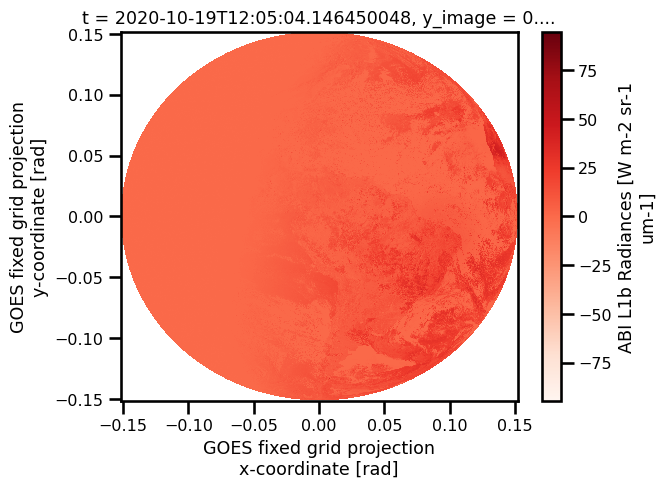

In [28]:
fig, ax = plt.subplots()

xr_ds.Rad.plot.imshow(ax=ax, cmap="Reds")

plt.show()

## Reprojection

In [9]:
%%time
xr_ds_ = reproject_goes16(xr_ds)

CPU times: user 25.3 s, sys: 640 ms, total: 26 s
Wall time: 26.1 s


In [10]:
xr_ds_

<xarray.Dataset>
Dimensions:                                           (x: 11173, y: 10513,
                                                       number_of_time_bounds: 2,
                                                       number_of_image_bounds: 2,
                                                       num_star_looks: 24)
Coordinates:
  * x                                                 (x) float64 -156.3 ... ...
  * y                                                 (y) float64 76.4 ... -7...
    t                                                 datetime64[ns] 2020-10-...
    x_image                                           float32 0.0
    y_image                                           float32 0.0
    goes_imager_projection                            int64 0
    t_star_look                                       (num_star_looks) datetime64[ns] ...
    band_wavelength_star_look                         (num_star_looks) float32 ...
Dimensions without coordinates: number_of_time_bounds, number_of_image_bounds,
                                num_star_looks
Data variables: (12/36)
    Rad                                               (y, x) float32 nan ... nan
    DQF                                               (y, x) float32 nan ... nan
    time_bounds                                       (number_of_time_bounds) datetime64[ns] ...
    y_image_bounds                                    (number_of_image_bounds) float32 ...
    x_image_bounds                                    (number_of_image_bounds) float32 ...
    nominal_satellite_subpoint_lat                    float32 ...
    ...                                                ...
    algorithm_dynamic_input_data_container            int32 ...
    processing_parm_version_container                 int32 ...
    algorithm_product_version_container               int32 ...
    star_id                                           (num_star_looks) float32 ...
    channel_integration_time                          float64 ...
    channel_gain_field                                float64 ...
Attributes: (12/30)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    production_site:           WCDAS
    ...                        ...
    timeline_id:               ABI Mode 6
    date_created:              2020-10-19T12:09:55.3Z
    time_coverage_start:       2020-10-19T12:00:18.7Z
    time_coverage_end:         2020-10-19T12:09:49.5Z
    LUT_Filenames:             SpaceLookParams(FM1A_CDRL79RevP_PR_09_00_02)-6...
    id:                        f96d9208-8455-4255-80ae-bec31f065387

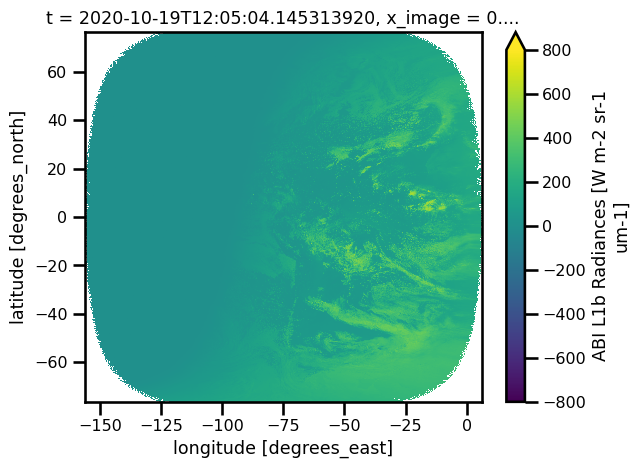

In [12]:
fig, ax = plt.subplots()

xr_ds_.Rad.plot.imshow(ax=ax, vmin=-800, vmax=800)

plt.show()

## Subsample

In [13]:
%%time
ds_new = resample_goes16(ds=xr_ds, scale=10.0)
ds_new

CPU times: user 43.1 s, sys: 7.08 s, total: 50.2 s
Wall time: 41.7 s


<xarray.Dataset>
Dimensions:                 (band: 1, y: 1085, x: 1085)
Coordinates:
  * x                       (x) float64 -0.1519 -0.1516 ... 0.1516 0.1519
  * y                       (y) float64 -0.1519 -0.1516 ... 0.1516 0.1519
  * band                    (band) int8 1
    t                       datetime64[ns] 2020-10-19T12:05:04.145313920
    y_image                 float32 0.0
    x_image                 float32 0.0
Data variables:
    Rad                     (band, y, x) float64 nan nan nan nan ... nan nan nan
    goes_imager_projection  int32 ...
Attributes: (12/30)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    production_site:           WCDAS
    ...                        ...
    timeline_id:               ABI Mode 6
    date_created:              2020-10-19T12:09:55.3Z
    time_coverage_start:       2020-10-19T12:00:18.7Z
    time_coverage_end:         2020-10-19T12:09:49.5Z
    LUT_Filenames:             SpaceLookParams(FM1A_CDRL79RevP_PR_09_00_02)-6...
    id:                        f96d9208-8455-4255-80ae-bec31f065387

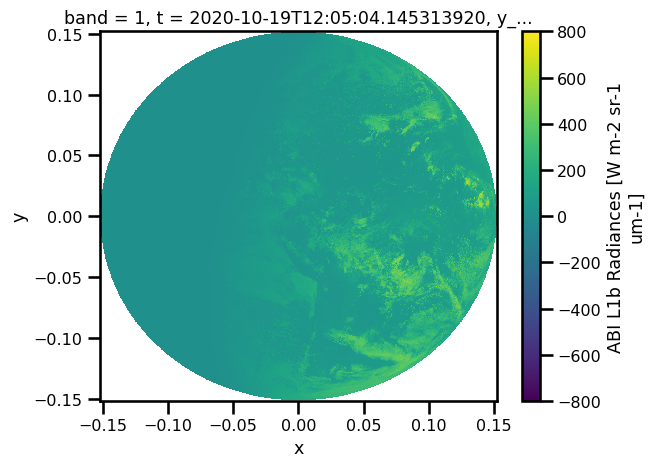

In [13]:
fig, ax = plt.subplots()

ds_new.Rad.isel(band=0).plot.imshow(ax=ax, vmin=-800, vmax=800)

plt.show()

## Reprojection (Revisited)

In [14]:
%%time
ds_new = reproject_goes16(ds_new)

CPU times: user 555 ms, sys: 15.3 ms, total: 570 ms
Wall time: 572 ms


In [15]:
ds_new

<xarray.Dataset>
Dimensions:                 (x: 1197, y: 960, band: 1)
Coordinates:
  * x                       (x) float64 -156.2 -156.0 -155.9 ... 4.127 4.261
  * y                       (y) float64 64.32 64.19 64.06 ... -64.18 -64.31
    x_image                 float32 0.0
    y_image                 float32 0.0
    t                       datetime64[ns] 2020-10-19T12:05:04.145313920
  * band                    (band) int8 1
    goes_imager_projection  int64 0
Data variables:
    Rad                     (band, y, x) float64 1.798e+308 ... 1.798e+308
Attributes: (12/30)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    production_site:           WCDAS
    ...                        ...
    timeline_id:               ABI Mode 6
    date_created:              2020-10-19T12:09:55.3Z
    time_coverage_start:       2020-10-19T12:00:18.7Z
    time_coverage_end:         2020-10-19T12:09:49.5Z
    LUT_Filenames:             SpaceLookParams(FM1A_CDRL79RevP_PR_09_00_02)-6...
    id:                        f96d9208-8455-4255-80ae-bec31f065387

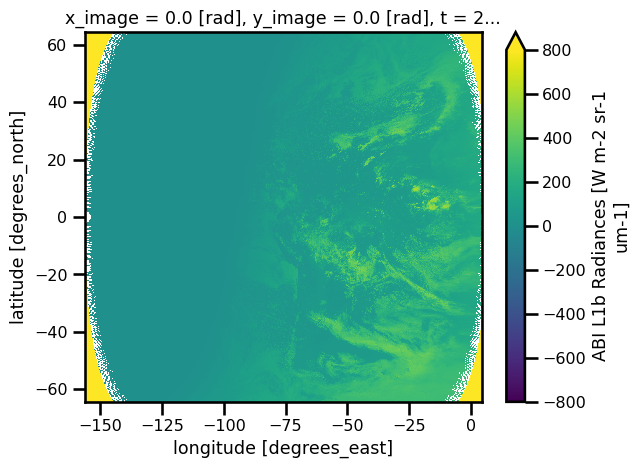

In [16]:
fig, ax = plt.subplots()

ds_new.Rad.isel(band=0).plot.imshow(ax=ax, vmin=-800, vmax=800)

plt.show()

## Multiple...

In [17]:
import pyinterp
import pyinterp.backends.xarray
import pyinterp.tests

In [9]:
def preprocess(ds):
    # # resize, e.g., coarsen, select subset
    # ds = ds.coarsen(x=10, y=10, boundary="trim").mean()
    indices = slice(0, None, 8)
    ds = ds.isel(x=indices, y=indices)

    # extract variables of interest, e.g., RAD
    ds = ds[["Rad", "goes_imager_projection"]]
    
    # reproject, e.g., EPSG:4326
    ds = reproject_goes(ds)
    
    # compute transformation, e.g., reflectance
    
    return ds

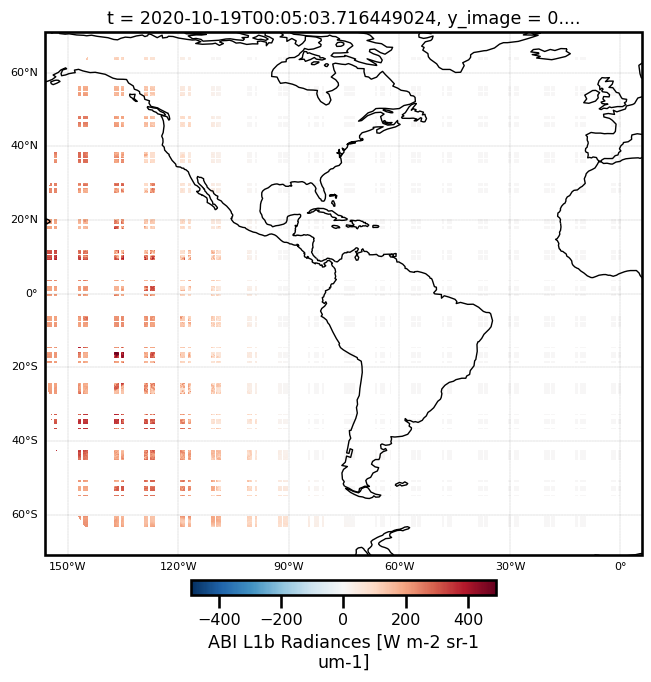

In [14]:
fig, ax = plt.subplots(figsize=(10,7), subplot_kw={'projection': ccrs.PlateCarree()})

step = 0
band = 0
cbar_kwargs = {
    "fraction": 0.027, 
    "pad": 0.045, 
    "orientation": "horizontal"
}
xr_ds.isel(band=band).Rad.plot.pcolormesh(ax=ax, cmap="RdBu_r", transform=ccrs.PlateCarree(), cbar_kwargs=cbar_kwargs)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.1, color='k', alpha=1, 
                  linestyle='--')

ax.coastlines(linewidth=1)
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8} 

plt.tight_layout()
plt.show()

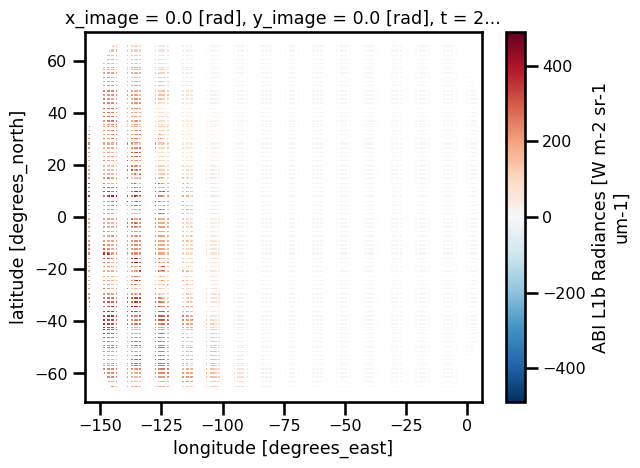

In [65]:
fig, ax = plt.subplots()

xr_ds.Rad.isel(band=0).plot.imshow(ax=ax)
plt.show()

In [52]:
%%time 

out = reproject(xr_ds)
out

CPU times: user 26.5 s, sys: 735 ms, total: 27.2 s
Wall time: 27.3 s


In [37]:
sat_height = xr_ds.goes_imager_projection.attrs["perspective_point_height"]
xr_da = xr_da.assign_coords({"x": xr_da.x.values * sat_height})
xr_da = xr_da.assign_coords({"y": xr_da.y.values * sat_height})

xr_da

<xarray.DataArray 'Rad' (y: 10848, x: 10848)>
[117679104 values with dtype=float32]
Coordinates:
    t        datetime64[ns] ...
  * y        (y) float64 5.434e+06 5.433e+06 5.432e+06 ... -5.433e+06 -5.434e+06
  * x        (x) float64 -5.434e+06 -5.433e+06 ... 5.433e+06 5.434e+06
    y_image  float32 ...
    x_image  float32 ...
Attributes:
    long_name:              ABI L1b Radiances
    standard_name:          toa_outgoing_radiance_per_unit_wavelength
    sensor_band_bit_depth:  10
    valid_range:            [   0 1022]
    units:                  W m-2 sr-1 um-1
    resolution:             y: 0.000028 rad x: 0.000028 rad
    grid_mapping:           goes_imager_projection
    cell_methods:           t: point area: point
    ancillary_variables:    DQF

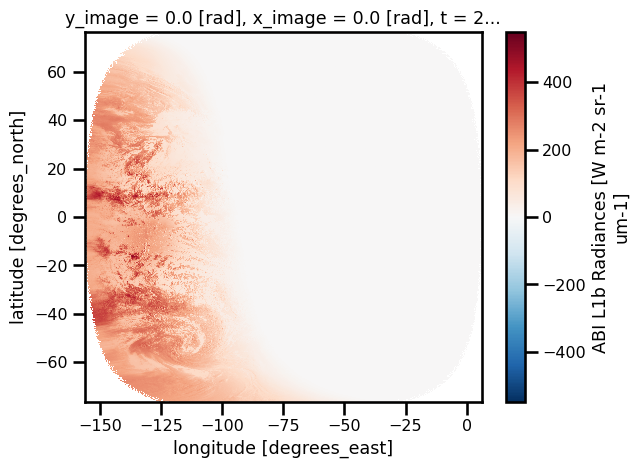

In [48]:
xr_da.plot.imshow()

In [42]:
xr_da

<xarray.DataArray 'Rad' (y: 10513, x: 11173)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * x                       (x) float64 -156.3 -156.3 -156.2 ... 6.096 6.111
  * y                       (y) float64 76.4 76.38 76.37 ... -76.38 -76.39
    y_image                 float32 0.0
    x_image                 float32 0.0
    t                       datetime64[ns] 2020-10-19T00:05:03.716449024
    goes_imager_projection  int64 0
Attributes:
    long_name:              ABI L1b Radiances
    standard_name:          toa_outgoing_radiance_per_unit_wavelength
    sensor_band_bit_depth:  10
    valid_range:            [   0 1022]
    units:                  W m-2 sr-1 um-1
    resolution:             y: 0.000028 rad x: 0.000028 rad
    grid_mapping:           goes_imager_projection
    cell_methods:           t: point area: point
    ancillary_variables:    DQF

In [44]:
xr_da.rio.crs

CRS.from_epsg(4326)

In [46]:
xr_source = XarraySource(xr_da, crs_transformer=xr_da.rio.crs)

ValueError: If temporal=False, data_array must have 3 dimensions: "x", "y", and "band" (in any order).

In [47]:
xr_da

<xarray.DataArray 'Rad' (y: 10513, x: 11173)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * x                       (x) float64 -156.3 -156.3 -156.2 ... 6.096 6.111
  * y                       (y) float64 76.4 76.38 76.37 ... -76.38 -76.39
    y_image                 float32 0.0
    x_image                 float32 0.0
    t                       datetime64[ns] 2020-10-19T00:05:03.716449024
    goes_imager_projection  int64 0
Attributes:
    long_name:              ABI L1b Radiances
    standard_name:          toa_outgoing_radiance_per_unit_wavelength
    sensor_band_bit_depth:  10
    valid_range:            [   0 1022]
    units:                  W m-2 sr-1 um-1
    resolution:             y: 0.000028 rad x: 0.000028 rad
    grid_mapping:           goes_imager_projection
    cell_methods:           t: point area: point
    ancillary_variables:    DQF